Setup

In [53]:
import torch
from torch import nn
from torch.utils.data import DataLoader


from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import os
import sys
import joblib

# ------------------------------------------------------
# Add project root path (one level above /notebooks)
# ------------------------------------------------------

project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
if project_root not in sys.path:
    sys.path.append(project_root)

print("Project root:", project_root)


from src.model import BinaryClassifier
from src.dataset import BinaryDataset
from src.metrics import compute_metrics
from src.utils import plot_confusion_matrix 

# ------------------------------------------------------
# Device
# ------------------------------------------------------

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)
if device == "cuda":
    print("GPU:", torch.cuda.get_device_name(0))

# ------------------------------------------------------
# Directories for saving artifacts
# ------------------------------------------------------

visuals_path = os.path.join(project_root, "visuals")
models_path = os.path.join(project_root, "saved_models")

os.makedirs(visuals_path, exist_ok=True)
os.makedirs(models_path, exist_ok=True)

print("Visuals path:", visuals_path)
print("Model path:", models_path)


Project root: c:\Users\Saparbek\Amanbay_Tech\binary_classification_project
Using device: cuda
GPU: NVIDIA GeForce RTX 3050 Laptop GPU
Visuals path: c:\Users\Saparbek\Amanbay_Tech\binary_classification_project\visuals
Model path: c:\Users\Saparbek\Amanbay_Tech\binary_classification_project\saved_models


Load dataset

In [54]:
data = load_breast_cancer()
X = data.data
y = data.target

print("X shape:", X.shape)
print("y shape:", y.shape)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("Train:", X_train.shape, "Test:", X_test.shape)

X shape: (569, 30)
y shape: (569,)
Train: (455, 30) Test: (114, 30)


Scaling + save scaler

In [55]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

joblib.dump(scaler, os.path.join(models_path, "scaler.pkl"))
print("Scaler saved to:", os.path.join(models_path, "scaler.pkl"))

Scaler saved to: c:\Users\Saparbek\Amanbay_Tech\binary_classification_project\saved_models\scaler.pkl


Dataset + DataLoader

In [56]:
train_ds = BinaryDataset(X_train, y_train)
test_ds = BinaryDataset(X_test, y_test)

train_dl = DataLoader(train_ds, batch_size=32, shuffle=True)
test_dl = DataLoader(test_ds, batch_size=32)

batch_x, batch_y = next(iter(train_dl))
print("Batch:", batch_x.shape, batch_y.shape)

Batch: torch.Size([32, 30]) torch.Size([32, 1])


Initialize model + training variables

In [57]:
in_features = X_train.shape[1]

model = BinaryClassifier(in_features).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
loss_fn = nn.BCEWithLogitsLoss()

epochs = 100
train_losses = []

model

BinaryClassifier(
  (model): Sequential(
    (0): Linear(in_features=30, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=1, bias=True)
  )
)

Training Loop

In [58]:
for epoch in range(epochs):
    model.train()
    total_loss = 0

    for batch_x, batch_y in train_dl:
        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)

        preds = model(batch_x)
        loss = loss_fn(preds, batch_y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        
    avg_loss = total_loss / len(train_dl)
    train_losses.append(avg_loss)

    model.eval()
    with torch.no_grad():
        all_preds = []
        all_true = []
        
        for X_batch, y_batch in test_dl:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            preds = model(X_batch)
            
            all_preds.append(preds)
            all_true.append(y_batch)
        all_preds = torch.cat(all_preds)
        all_true = torch.cat(all_true)
        
        metrics = compute_metrics(all_true, all_preds)
    
    print(f"Epoch {epoch}: Loss={avg_loss:.4f}, Acc={metrics['accuracy']:.4f}")


Epoch 0: Loss=0.3197, Acc=0.9649
Epoch 1: Loss=0.0919, Acc=0.9825
Epoch 2: Loss=0.0725, Acc=0.9825
Epoch 3: Loss=0.0593, Acc=0.9912
Epoch 4: Loss=0.0499, Acc=0.9912
Epoch 5: Loss=0.0478, Acc=0.9912
Epoch 6: Loss=0.0411, Acc=0.9912
Epoch 7: Loss=0.0367, Acc=0.9912
Epoch 8: Loss=0.0341, Acc=0.9825
Epoch 9: Loss=0.0319, Acc=0.9825
Epoch 10: Loss=0.0292, Acc=0.9825
Epoch 11: Loss=0.0254, Acc=0.9825
Epoch 12: Loss=0.0273, Acc=0.9825
Epoch 13: Loss=0.0220, Acc=0.9825
Epoch 14: Loss=0.0197, Acc=0.9825
Epoch 15: Loss=0.0189, Acc=0.9825
Epoch 16: Loss=0.0199, Acc=0.9825
Epoch 17: Loss=0.0166, Acc=0.9825
Epoch 18: Loss=0.0368, Acc=0.9649
Epoch 19: Loss=0.0180, Acc=0.9825
Epoch 20: Loss=0.0156, Acc=0.9912
Epoch 21: Loss=0.0137, Acc=0.9825
Epoch 22: Loss=0.0108, Acc=0.9825
Epoch 23: Loss=0.0092, Acc=0.9825
Epoch 24: Loss=0.0087, Acc=0.9825
Epoch 25: Loss=0.0075, Acc=0.9825
Epoch 26: Loss=0.0071, Acc=0.9825
Epoch 27: Loss=0.0065, Acc=0.9825
Epoch 28: Loss=0.0065, Acc=0.9825
Epoch 29: Loss=0.0056, A

Plot loss curve + save

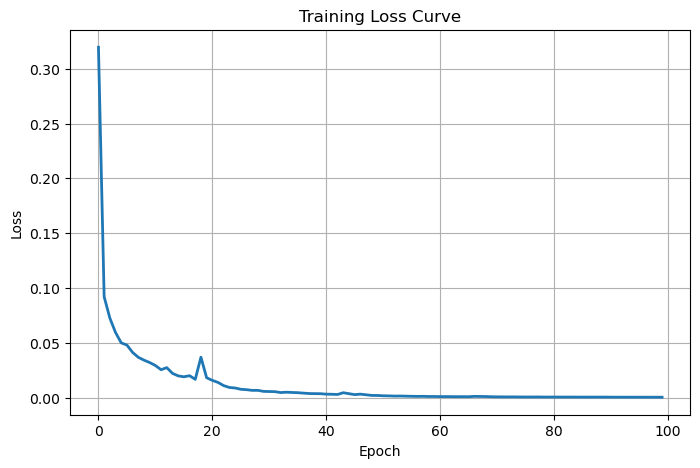

<Figure size 640x480 with 0 Axes>

Saved: c:\Users\Saparbek\Amanbay_Tech\binary_classification_project\visuals\loss.png


In [59]:
plt.figure(figsize=(8,5))
plt.plot(train_losses, label="Train Loss", linewidth=2)
plt.title("Training Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

plt.savefig(os.path.join(visuals_path, "loss.png"), dpi=300, bbox_inches="tight")
plt.show()

print("Saved:", os.path.join(visuals_path, "loss.png"))

Confusion Matrix (compute & optional plot)

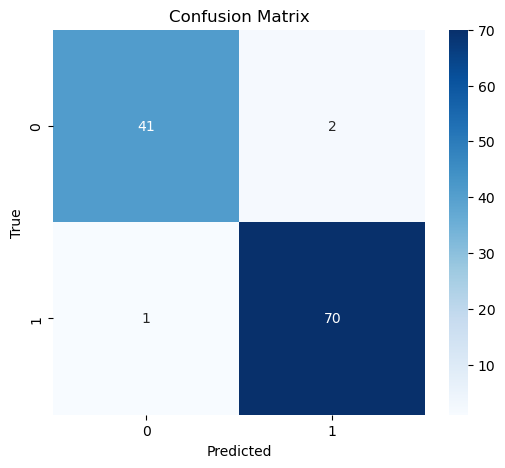

<Figure size 640x480 with 0 Axes>

In [60]:
# Compute confusion matrix as numbers and save it. Plot only if plotting libs exist.
y_pred = (torch.sigmoid(all_preds) > 0.5).cpu().numpy().astype(int)
y_true = all_true.cpu().numpy().astype(int)

plot_confusion_matrix(y_true, y_pred)
plt.savefig(os.path.join(visuals_path, "confusion_matrix.png"), dpi=300, bbox_inches="tight")


Save trained model

In [61]:
model_save_path = os.path.join(models_path, "model.pth")
torch.save(model.state_dict(), model_save_path)

print("Model saved to: ", model_save_path)

Model saved to:  c:\Users\Saparbek\Amanbay_Tech\binary_classification_project\saved_models\model.pth


Test inference (load saved model)

In [62]:
loaded_model = BinaryClassifier(in_features)
loaded_model.load_state_dict(torch.load(model_save_path, map_location="cpu"))
loaded_model.eval()

sample_scaled = X_test[0].reshape(1, -1) 

sample_tensor = torch.tensor(sample_scaled, dtype=torch.float32)

with torch.no_grad():
    logit = loaded_model(sample_tensor)
    prob = torch.sigmoid(logit).item()
    pred_class = int(prob > 0.5)

print("Real:", y_test[0])
print("Logit:", logit.item())
print("Prob:", prob)
print("Pred class:", pred_class)


Real: 1
Logit: 7.734021186828613
Prob: 0.9995624423027039
Pred class: 1
